In [1]:
from lightglue_onnx import DISK, LightGlue, LightGlueEnd2End, SuperPoint
from lightglue_onnx.end2end import normalize_keypoints
from lightglue_onnx.utils import load_image, rgb_to_grayscale

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
torch.set_grad_enabled(False)

In [3]:
device = "cuda:0"
extractor = SuperPoint(max_num_keypoints=2048, detection_threshold=0.0).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", depth_confidence=-1, width_confidence=-1).eval().to(device)  # create the matcher

Loaded LightGlue model


In [4]:
pipeline = LightGlueEnd2End(extractor, matcher).eval()

In [5]:
class SuperPointV2(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.extractor = extractor
        self.max_num_keypoints = extractor.conf.max_num_keypoints

    def forward(self, image1):
        # RGB -> Grayscale
        image1 = TF.rgb_to_grayscale(image1)
        kpts0 = self.extractor(image1)[0]
        
        _, P, _ = kpts0.shape
        kpts0 = F.pad(kpts0, (0, 0, 0, self.max_num_keypoints - P), value=-1)
        
        return kpts0

In [6]:
class LighGlueEnd2EndV2(nn.Module):
    def __init__(self, pipeline):
        super().__init__()
        self.pipeline = pipeline
        self.max_num_keypoints = pipeline.extractor.conf.max_num_keypoints

    def forward(self, image1, image2):
        # RGB -> Grayscale
        image1 = TF.rgb_to_grayscale(image1)
        image2 = TF.rgb_to_grayscale(image2)
        kpts0, kpts1, matches, scores = pipeline(image1, image2)
        kpts0 = kpts0[0][matches[:, 0]]
        kpts1 = kpts1[0][matches[:, 1]]
        
        
        kpts0_pad = kpts0.new_full((self.max_num_keypoints, 2), fill_value=-1)
        kpts0_pad[:kpts0.shape[0]] = kpts0
        
        kpts1_pad = kpts1.new_full((self.max_num_keypoints, 2), fill_value=-1)
        kpts1_pad[:kpts1.shape[0]] = kpts1
        
        scores_pad = scores.new_full((self.max_num_keypoints,), fill_value=-1)
        scores_pad[:scores.shape[0]] = scores
        
        return kpts0_pad, kpts1_pad, scores_pad

In [7]:
from pathlib import Path
images = Path("assets")
img_size = (600, 800)

In [8]:
image0, _ = load_image(f"{images}/DSC_0411.JPG", resize=img_size)
image1, _ = load_image(f"{images}/DSC_0410.JPG", resize=img_size)
output = LighGlueEnd2EndV2(pipeline)(image0[None].cuda(), image1[None].cuda())

In [9]:
output[0][0, :]

tensor([656., 295.], device='cuda:0')

In [10]:
output[1][0, :]

tensor([666., 291.], device='cuda:0')

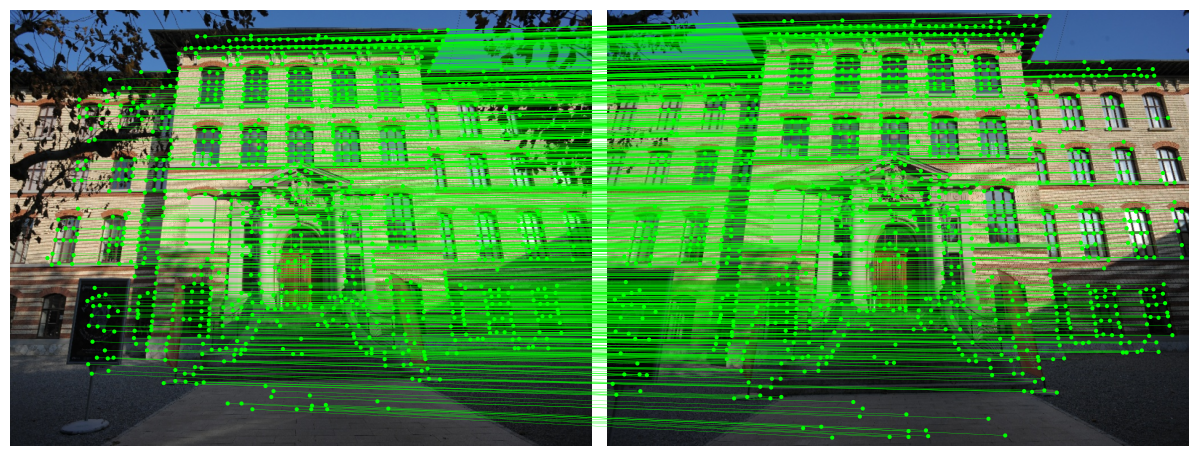

In [11]:
from lightglue import viz2d

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(output[0][output[2] != -1], output[1][output[2] != -1], color="lime", lw=0.2)

In [46]:
kp_1 = torch.Tensor([
    [523, 108],
[403,  98],
[370, 270],
[ 88, 234],
[462,  98],
[404, 197],
[276, 197],
[278, 181],
[400, 331],
[392,  98],
[659, 310],
[526, 271],
[284,  99],
[352, 198],
[149, 233],
[263, 402],
[272,  52],
[586, 230],
[344,  85],
[329, 235],
[423, 283],
[533, 210],
[331, 242],
[ 76, 300],
[ 73, 316],
[403, 123],
[282, 123],
[208, 162],
[328, 198],
[331, 122],
[ 87, 300],
[599, 329],
[305, 405],
[510,  98],
[ 58, 335],
[717, 295],
[445, 410],
[456, 197],
[643, 216],
[150, 219],
[624, 159],
[528, 165],
[645, 295],
[322,  81],
[273, 440],
[201, 219],
[538, 389],
[332, 108],
[331, 364],
[330, 325],
[272,  99],
[404, 166],
[342, 121],
[105, 146],
[340, 198],
[293,  98],
[508, 409],
[341, 180],
[146, 323],
[707, 295],
[141, 219],
[386, 331],
[527, 288],
[285,  87],
[518, 180],
[354, 235],
[426, 293],
[342, 151],
[716, 342],
[294,  82],
[462, 108],
[159, 220],
[344, 108],
[210, 283],
[710, 310],
[320, 324],
[530, 180],
[249, 401],
[137, 314],
[468, 197],
[641, 203],
[295, 250],
[382,  98],
[511, 108],
[499, 332],
[315, 263],
[392, 197],
[474, 108],
[114, 407],
[249,  52],
[483, 323],
[515, 480],
[190, 288],
[263, 424],
[461,  51],
[631, 144],
[691, 453],
[451,  98],
[674, 404],
[393,  41],
[333, 402],
[456, 265],
[666, 425],
[346, 387],
[344, 253],
[100, 162],
[330, 337],
[159, 233],
[474,  97],
[601, 472],
[122, 348],
[444, 265],
[266, 181],
[520, 196],
[533,  81],
[364, 230],
[429, 306],
[481,  51],
[621, 145],
[263, 364],
[540, 289],
[209, 148],
[650, 327],
[332, 305],
[264, 212],
[160, 161],
[331,  41],
[444,  40],
[392, 181],
[468, 212],
[136, 408],
[254, 181],
[333,  51],
[646, 230],
[524, 381],
[321, 108],
[331, 292],
[374, 227],
[543, 325],
[457, 249],
[ 82, 218],
[544,  51],
[534, 108],
[265, 197],
[ 92, 308],
[323,  51],
[543, 196],
[501, 359],
[393, 274],
[362,  41],
[606, 297],
[304, 272],
[656, 295],
[240, 500],
[523, 123],
[715, 282],
[513, 122],
[633, 216],
[392, 123],
[241,  53],
[466, 166],
[424, 269],
[141, 284],
[332, 265],
[682, 133],
[664, 343],
[271, 123],
[521, 210],
[585, 129],
[566, 496],
[238, 402],
[629, 131],
[254, 491],
[434, 242],
[412, 530],
[279, 166],
[262, 353],
[634, 159],
[480, 197],
[362, 524],
[352, 181],
[653, 343],
[154, 322],
[538, 271],
[319, 337],
[394, 549],
[354, 108],
[291, 450],
[199, 233],
[574, 493],
[422,  40],
[551, 487],
[381,  81],
[ 67, 348],
[411, 233],
[519, 307],
[663, 404],
[111, 164],
[128, 299],
[318, 541],
[531, 196],
[436, 549],
[502, 109],
[362, 392],
[255,  60],
[ 65, 301],
[143, 442],
[528, 464],
[383,  51],
[704, 230],
[343,  98],
[529, 307],
[685, 225],
[455, 402],
[444, 253],
[551, 270],
[485, 388],
[329, 390],
[274,  85],
[502,  98],
[439, 156],
[532, 326],
[631, 102],
[341, 166],
[521,  98],
[373, 411],
[521,  87],
[218,  84],
[515, 257],
[364, 411],
[196, 167],
[739, 404],
[455, 393],
[414, 108],
[215, 459],
[588, 244],
[541, 180],
[147, 314],
[326, 437],
[442, 115],
[533,  97],
[225, 405],
[414,  81],
[434, 260],
[282,  51],
[277, 467],
[204, 341],
[504,  40],
[680, 443],
[126, 315],
[399, 215],
[211, 272],
[ 98, 234],
[517, 292],
[314,  59],
[767, 294],
[558,  58],
[512,  52],
[346, 288],
[582,  70],
[318, 388],
[691, 215],
[669, 295],
[470, 400],
[415,  97],
[218, 450],
[373, 394],
[455, 165],
[661, 324],
[105, 135],
[123, 406],
[353,  51],
[262,  81],
[501, 373],
[467, 181],
[198, 247],
[647, 310],
[654, 400],
[721, 309],
[505, 430],
[541, 488],
[332,  98],
[451, 108],
[149, 299],
[596, 311],
[294, 483],
[654, 282],
[412,  39],
[241, 511],
[397, 263],
[608, 404],
[442,  51],
[175, 331],
[492,  58],
[595, 295],
[463,  41],
[578, 198],
[356, 333],
[414, 247],
[246, 258],
[478, 309],
[391, 404],
[404, 181],
[267, 166],
[159, 286],
[455, 181],
[566,  64],
[635, 230],
[415, 544],
[342,  41],
[392,  85],
[262,  99],
[601, 385],
[322,  91],
[170, 450],
[438, 286],
[602,  27],
[527, 446],
[ 93, 208],
[310, 467],
[178, 394],
[299, 350],
[209, 131],
[122, 393],
[346, 402],
[648, 243],
[576, 507],
[372, 332],
[516, 489],
[724, 327],
[301, 334],
[130, 468],
[456, 305],
[135, 331],
[537, 255],
[138, 234],
[726, 342],
[454, 289],
[339, 212],
[344, 265],
[217, 162],
[273, 449],
[392, 165],
[520, 327],
[202, 333],
[477, 404],
[586,  61],
[321,  40],
[393,  51],
[ 95, 286],
[492,  74],
[330, 166],
[608, 311],
[743, 421],
[483, 259],
[200, 376],
[211, 206],
[672, 384],
[643, 281],
[596, 230],
[313,  51],
[406, 273],
[173, 353],
[ 95, 147],
[587, 159],
[609, 415],
[308, 482],
[403,  40],
[264, 473],
[595, 215],
[703, 280],
[586, 145],
[136, 323],
[278, 354],
[756, 243],
[392, 108],
[479, 180],
[669, 443],
[505, 250],
[196, 420],
[198, 396],
[328, 212],
[169, 219],
[533,  51],
[139, 298],
[214, 468],
[452, 116],
[442,  98],
[364, 274],
[483, 145],
[305, 413],
[571, 480],
[484,  40],
[632, 453],
[329, 181],
[473, 388],
[538,  59],
[510, 196],
[497, 259],
[108, 434],
[454,  40],
[369, 257],
[382,  90],
[470, 236],
[292, 434],
[604, 103],
[ 92, 219],
[492, 419],
[133, 125],
[436, 434],
[474,  81],
[288, 182],
[677, 424],
[371, 359],
[280, 290],
[148, 414],
[116, 178],
[343,  51],
[462,  86],
[403,  51],
[391, 211],
[511, 210],
[510,  87],
[737, 383],
[527, 410],
[510,  79],
[318, 182],
[331, 278],
[605, 124],
[125, 478],
[714, 332],
[129, 441],
[545, 455],
[567, 115],
[575, 145],
[430, 409],
[320, 279],
[738, 342],
[333,  85],
[442, 273],
[554,  51],
[642, 321],
[274, 212],
[213, 249],
[250, 387],
[740, 464],
[354,  81],
[400, 309],
[474, 377],
[371,  40],
[201, 205],
[402, 108],
[185, 331],
[396, 410],
[187, 459],
[729, 404],
[120, 155],
[680, 160],
[614, 472],
[187, 234],
[522,  51],
[474,  40],
[553, 288],
[456, 257],
[452,  51],
[576,  84],
[463, 122],
[465, 259],
[503, 395],
[260, 122],
[508, 163],
[301,  42],
[569, 415],
[694, 230],
[164, 107],
[292, 122],
[718, 388],
[542, 307],
[385, 222],
[303,  51],
[293,  51],
[ 85, 349],
[381, 181],
[130, 110],
[479, 277],
[590,  52],
[354,  91],
[728, 443],
[645, 343],
[500,  81],
[261,  52],
[635, 171],
[381, 198],
[ 62, 316],
[601, 394],
[212, 513],
[617, 177],
[241, 248],
[293, 117],
[253, 365],
[696, 246],
[471, 366],
[343, 376],
[282, 259],
[355, 410],
[621, 389],
[471,  51],
[266, 512],
[437,  64],
[152, 131],
[333, 419],
[412,  51],
[227, 495],
[526,  41],
[ 57, 350],
[467, 243],
[194, 440],
[608, 445],
[135, 421],
[733, 299],
[202, 354],
[283, 374],
[471, 418],
[441, 132],
[232,  80],
[428,  95],
[416, 197],
[151, 146],
[476, 458],
[420,  58],
[479, 434],
[123, 131],
[312, 455],
[623, 414],
[135, 496],
[606, 435],
[492,  51],
[374,  74],
[354,  98],
[397, 295],
[441,  81],
[224, 412],
[414, 549],
[685, 389],
[199, 388],
[219, 135],
[320, 293],
[165, 249],
[171, 205],
[763, 279],
[176, 403],
[674, 320],
[486, 406],
[397, 226],
[195, 428],
[524, 254],
[ 66, 288],
[257,  36],
[359,  58],
[517, 165],
[181, 276],
[116, 382],
[685, 403],
[314,  75],
[774, 213],
[213, 258],
[496, 299],
[175, 134],
[465, 249],
[382,  40],
[482, 354],
[171, 366],
[566,  52],
[381, 268],
[412,  64],
[502,  51],
[230,  95],
[150, 349],
[446, 198],
[324, 459],
[640, 144],
[432,  50],
[562,  80],
[286, 213],
[683, 171],
[500, 352],
[750, 115],
[494, 271],
[456, 212],
[381, 117],
[463, 434],
[595,  42],
[276, 382],
[186, 482],
[385, 246],
[253, 376],
[641, 129],
[434,  37],
[345, 306],
[441, 109],
[404, 340],
[180, 291],
[543, 446],
[416, 214],
[435, 275],
[397, 148],
[722,  93],
[112, 500],
[272, 109],
[ 83, 317],
[113, 397],
[685, 200],
[365, 240],
[515, 272],
[320, 122],
[540, 399],
[463, 324],
[276, 368],
[178, 306],
[526, 424],
[569, 126],
[432,  58],
[219, 146],
[247, 425],
[247, 446],
[352,  40],
[468, 306],
[292, 423],
[185, 341],
[568, 424],
[465, 292],
[657, 418],
[413, 405],
[610, 326],
[276, 390],
[497, 472],
[353, 121],
[244, 289],
[293,  66],
[497, 466],
[221, 179],
[625, 172],
[268,  36],
[371, 434],
[376, 216],
[555, 307],
[300,  60],
[314, 399],
[451, 123],
[209, 233],
[332, 452],
[293, 109],
[393, 387],
[451,  85],
[558, 328],
[352, 191],
[659, 437],
[654,  94],
[484, 336],
[183, 348],
[551, 374],
[380, 388],
[419, 289],
[149, 115],
[621, 404],
[508, 180],
[323, 467],
[614, 102],
[488, 396],
[428, 332],
[322,  97],
[403,  86],
[551, 256],
[264, 387],
[421,  50],
[278, 322],
[381, 405],
[515,  41],
[567, 402],
[638, 114],
[678, 102],
[588, 191],
[210, 220],
[591, 508],
[413, 388],
[462, 373],
[166, 346],
[323, 249],
[325, 272],
[381, 213],
[164, 412],
[573, 216],
[197, 406],
[303,  75],
[589, 280],
[395, 342],
[446, 212],
[238, 381],
[732, 421],
[690, 381],
[275, 398],
[720, 399],
[259,  66],
[573, 446],
[481, 293],
[155, 314],
[625, 432],
[302, 283],
[213, 481],
[613, 344],
[651, 452],
[548, 468],
[264, 377],
[363,  51],
[186, 251],
[446, 395],
[652, 389],
[726, 431],
[471,  64],
[472, 355],
[415, 258],
[494,  41],
[413, 345],
[388, 260],
[263, 289],
[414, 224],
[688, 416],
[413, 380],
[598, 368],
[627, 446],
[314, 253],
[364, 323],
[502, 133],
[278, 328],
[407, 250],
[180, 195],
[444, 163],
[223, 426],
[338, 159],
[272, 341],
[373,  51],
[338, 440],
[220, 197],
[261, 434],
[188, 468],
[351, 213],
[297, 388],
[308, 474],
[261, 109],
[463, 115],
[376, 253],
[553, 507],
[479,  58],
[775, 282],
[712, 324],
[722, 452],
[252, 212],
[570,  37],
[140, 116],
[454, 239],
[446, 243],
[348, 278],
[253, 197],
[416, 181],
[229,  52],
[425, 247],
[238, 425],
[501,  92],
[637, 245],
[600, 374],
[227, 510],
[274, 410],
[556, 458],
[605, 283],
[366, 245],
[353,  65],
[445, 182],
[173, 459],
[106, 400],
[701, 302],
[229, 106],
[416, 131],
[176, 145],
[374,  58],
[466, 271],
[353, 132],
[252, 501],
[434, 543],
[761, 159],
[684,  93],
[598, 361],
[247,  37],
[548, 427],
[520, 548],
[460, 365],
[461, 397],
[648, 102],
[274, 418],
[155, 107],
[341, 272],
[479, 163],
[563, 379],
[693, 444],
[317, 198],
[646, 173],
[489, 271],
[299, 541],
[477, 131],
[537,  36],
[535,  67],
[540, 242],
[753, 230],
[475, 122],
[254, 161],
[705, 322],
[183, 269],
[209, 106],
[726, 384],
[523, 368],
[342, 189],
[461, 337],
[758, 444],
[712, 198],
[598, 246],
[623, 102],
[473, 450],
[374, 379],
[356, 280],
[366, 428],
[652, 200],
[585, 116],
[415, 122],
[415, 332],
[563,  28],
[352, 163],
[260, 448],
[297, 396],
[136, 248],
[466, 279],
[659, 102],
[538, 131],
[316, 215],
[119, 478],
[381, 147],
[750, 389],
[620, 196],
[364, 283],
[188, 314],
[662, 394],
[291, 132],
[446, 204],
[293, 408],
[433,  74],
[394, 253],
[273, 432],
[385, 305],
[104, 207],
[715, 102],
[304, 262],
[ 89, 317],
[775, 325],
[380, 131],
[484, 271],
[289, 163],
[610, 272],
[156, 306],
[342, 428],
[675, 329],
[298, 374],
[253, 136],
[283, 109],
[329, 378],
[433, 231],
[753, 412],
[416, 163],
[429, 132],
[768, 307],
[512, 115],
[356, 265],
[444, 168],
[723, 417],
[700, 452],
[748, 240],
[132, 391],
[517, 149],
[258, 131],
[134, 478],
[318, 409],
[699, 290],
[227, 118],
[594, 202],
[545, 214],
[716, 246],
[653, 215],
[153, 205],
[499, 344],
[660, 385],
[333, 549],
[191, 450],
[727, 281],
[306, 252],
[481, 214],
[498, 321],
[220, 104],
[578,  95],
[611, 423],
[169, 228],
[176, 324],
[319, 133],
[643, 452],
[232,  60],
[687, 233],
[637, 289],
[654, 270],
[331,  36],
[540, 170],
[548,  36],
[623, 424],
[139, 377],
[189, 305],
[590, 109],
[589, 174],
[401, 158],
[158, 281],
[370,  94],
[630, 200],
[318,  65],
[478,  73],
[541, 162],
[660, 445],
[181, 131],
[689, 241],
[619, 378],
[201, 364],
[689, 426],
[423, 433],
[719, 463],
[576, 190],
[535, 122],
[404, 264],
[582,  41],
[659, 246],
[401, 473],
[733, 102],
[439, 395],
[631, 274],
[431, 193],
[141, 478],
[289, 174],
[570, 475],
[704, 102],
[509, 189],
[677, 343],
[670, 309],
[381, 162],
[381, 170],
[699, 465],
[245, 271],
[ 91, 273],
[242, 321],
[643, 332],
[528, 149],
[642, 270],
[689, 103],
[364, 354],
[163, 279],
[584, 216],
[ 52, 341],
[219, 205],
[317, 474],
[741,  93],
[648, 380],
[659, 430],
[594, 283],
[468, 286],
[751, 404],
[731, 309],
[378,  64],
[627, 382],
[562, 507],
[665, 278],
[201, 196],
[381, 109],
[486, 464],
[298, 367],
[426, 124],
[190, 126],
[676,  82],
[186, 325],
[197, 117],
[404, 353],
[602,  84],
[547, 145],
[318, 467],
[288, 467],
[600, 379],
[523, 115],
[585,  28],
[318, 173],
[534, 489],
[752, 379],
[171, 441],
[176, 418],
[668, 466],
[389, 473],
[724, 102],
[536,  41],
[226, 131],
[345, 318],
[494, 450],
[363,  46],
[430, 418],
[194, 435],
[767, 245],
[613, 128],
[503, 123],
[560, 146],
[767, 269],
[670, 102],
[671, 157],
[501, 387],
[717, 220],
[ 95, 132],
[643, 159],
[355, 248],
[401, 208],
[375, 466],
[705, 206],
[380, 191],
[265, 459],
[112, 420],
[444, 426],
[672, 393],
[107, 220],
[263, 492],
[318, 160],
[707, 244],
[380, 157],
[692, 434],
[294,  91],
[424,  35],
[526,  36],
[152, 336],
[656, 409],
[149, 377],
[557, 315],
[180,  85],
[579, 172],
[394, 283],
[442, 123],
[482, 286],
[ 87, 337],
[574, 133],
[433, 429],
[113, 457],
[282, 276],
[352, 173],
[321, 116],
[767, 319],
[736, 394],
[263, 413],
[175, 423],
[157, 300],
[738, 452],
[752, 283],
[754, 417],
[490, 472],
[271, 116],
[222, 189],
[412, 410],
[404, 115],
[268, 253],
[288, 190],
[472, 445],
[515, 471],
[613, 454],
])

ValueError: x and y must be the same size

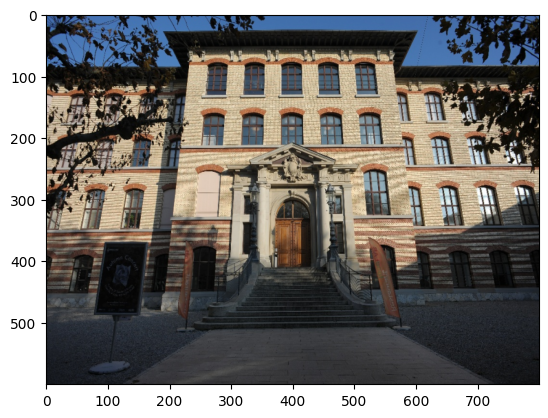

In [ ]:
torch.onnx.export(
    SuperPointV2(pipeline.extractor).eval(),
    (image0[None].cuda(),),
    "superpoint_v2.onnx",
    input_names=["image0"],
    output_names=[
        "kpts0",
    ],
    opset_version=17,
)

In [ ]:
torch.onnx.export(
    LighGlueEnd2EndV2(pipeline).eval(),
    (image0[None].cuda(), image1[None].cuda()),
    "lightglue_e2e_v2.onnx",
    input_names=["image0", "image1"],
    output_names=[
        "kpts0",
        "kpts1",
        "mscores",
    ],
    opset_version=17,
)

In [ ]:
! trtexec --onnx=superpoint_v2.onnx --saveEngine=superpoint_v2.engine --explicitBatch --fp16

In [ ]:
! trtexec --onnx=lightglue_e2e_v2.onnx --saveEngine=lightglue_e2e_v2.engine --explicitBatch --fp16